In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import pickle
from scipy.ndimage.measurements import label
from sklearn.preprocessing import StandardScaler
import time
from sklearn.svm import LinearSVC
from skimage.feature import hog
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split
from sklearn.svm import LinearSVC
from skimage.feature import hog

#For Multiple Detections & False Positives
from scipy.ndimage.measurements import label
import time
from moviepy.editor import VideoFileClip
#import imageio
#imageio.plugins.ffmpeg.download()


In [2]:
def convert_color(image, color_space='BGR2YCrCb'): #ndarray
    if color_space != 'RGB':
        if color_space == 'HSV':
            image_result = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            image_result = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            image_result = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            image_result = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'BGR2YCrCb':
            image_result = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
        elif color_space == 'YCrCb':
            image_result = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'GRAY':
            image_result = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else: image_result = np.copy(image)
    return image_result

In [3]:
def bin_spatial(img, size=(32, 32)): #ndarray
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))

In [4]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], 
                                    channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## Extracting the Histogram of Oriented Gradient

In [5]:
def get_hog_features(img, orient, pix_per_cell, 
                     cell_per_block,vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell,pix_per_cell),
                                  cells_per_block=(cell_per_block,cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

## Visualization of extracted Histogram of Oriented Gradient

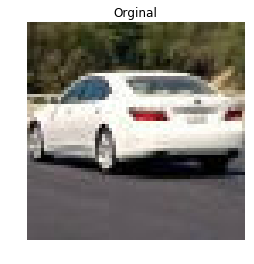

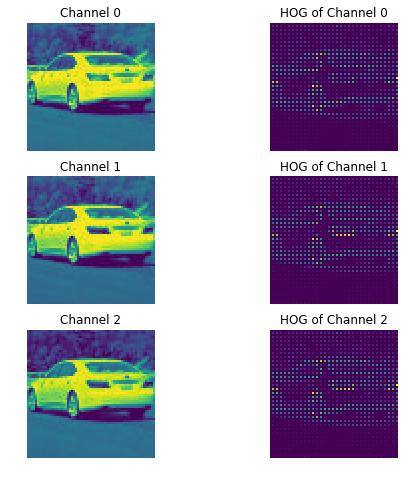

In [6]:
image = mpimg.imread('./all/1200.jpeg')

plt.imshow(image )
plt.title('Orginal')
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 8))
subplotcounter = 1
for channel in range(image.shape[2]):
    
    plt.subplot(3, 2, subplotcounter)
    plt.imshow(image[:,:,channel] )
    plt.title('Channel {}'.format(channel))
    plt.axis('off')
    subplotcounter = subplotcounter + 1

    plt.subplot(3, 2,subplotcounter )
    f,g = get_hog_features(image[:,:,channel], 9, 2,2,vis=True, feature_vec=True)
    plt.imshow(g )
    plt.title('HOG of Channel {}'.format(channel))
    plt.axis('off')
    subplotcounter = subplotcounter + 1

plt.show() 



## Display image with title

In [7]:
def showImage(image,title=""):
    plt.imshow(image )
    plt.title(title)
    plt.show()    

## Drawing boxes in an image

In [8]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

## Multiple Detections & False Positives
**Solution is Heat-Map**
<br>
To make a heat-map, you're simply going to add "heat" (+=1) for all pixels within windows where a positive detection is reported by your classifier.
<br>
If the classifier is working well, then the "hot" parts of the map are where the cars are, and by imposing a threshold, you can reject areas affected by false positives therefore we use the *apply_threshold* function.

In [9]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

I integrate a heat map over images, such that areas of multiple detections get "hot", while transient false positives stay "cool". I can then simply threshold the heatmap to remove false positives with this line.
```ruby
heatmap[heatmap <= threshold] = 0
```
<br>
once heat-map is thresholded, there are many ways to figure out how many cars we have in each frame and which pixels belong to which cars, but one of the most straightforward solutions is to use the *label()* function from *scipy.ndimage.measurements*.

In [10]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [11]:
def draw_labeled_bboxes(img, labels):
    
    font                   = cv2.FONT_HERSHEY_SIMPLEX
    bottomLeftCornerOfText = (10,500)
    fontScale              = 1
    fontColor              = (0,0,255)
    lineType               = 2    
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        bottomLeftCornerOfText = (np.min(nonzerox), np.min(nonzeroy))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
        cv2.putText(img,'Car{}'.format(car_number), 
                    bottomLeftCornerOfText, 
                    font, 
                    fontScale,
                    fontColor,
                    lineType)
    # Return the image
    return img

In [12]:
def extract_features(imgs, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_size=(32,32), hist_bins=32,
                        spatial_feat = True , hist_feat = True , hog_feat = True ):
    # Create a list to append feature vectors to
    features = []
    allfeatures = []
    
    # Iterate through the list of images
    for file in imgs:
        
        
        # Read in each one by one
        image = mpimg.imread(file)
        #image = image.astype(np.float32)/255
        
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image , color_space)

        # Apply bin_spatial() to get spatial color features
        if spatial_feat == True :
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            #print('spatial_features {}'.format(spatial_features.shape))
            allfeatures.append(spatial_features)
        
        if hist_feat == True :
            hist_features = color_hist(feature_image, nbins=hist_bins)
            #print('hist_features {}'.format(hist_features.shape))
            allfeatures.append(hist_features)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_feat == True :
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],orient, 
                                                         pix_per_cell, 
                                                         cell_per_block, 
                                                         vis=False, feature_vec=False))
                hog_features = np.ravel(hog_features)        
                #print('hog_features {}'.format(hog_features.shape))
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, 
                                                cell_per_block, 
                                                vis=False, feature_vec=False)
                #print('hog_features {}'.format(hog_features[0].shape))
            allfeatures.append(np.ravel(hog_features))

        # Append the new feature vector to the features list
        if len(allfeatures) == 1 :
            features.append(allfeatures[0])
            
        elif len(allfeatures) > 1:
            features.append(np.concatenate(allfeatures))
            
        allfeatures.clear()
    # Return list of feature vectors
    return features

In [13]:
def extract_featuresII(imgs, color_space='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_size=(32,32), hist_bins=32,
                        spatial_feat = True , hist_feat = True , hog_feat = True, scale = 0.25 ):
    # Create a list to append feature vectors to
    features = []
    allfeatures = []
    
    # Iterate through the list of images
    for file in imgs:
        
        
        # Read in each one by one
        image = mpimg.imread(file)
        #image = image.astype(np.float32)/255

        if scale != 1:
            imshape = image.shape
            image = cv2.resize(image, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
        
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(image , color_space)

        # Apply bin_spatial() to get spatial color features
        if spatial_feat == True :
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            #print('spatial_features {}'.format(spatial_features.shape))
            allfeatures.append(spatial_features)
        
        if hist_feat == True :
            hist_features = color_hist(feature_image, nbins=hist_bins)
            #print('hist_features {}'.format(hist_features.shape))
            allfeatures.append(hist_features)
        
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_feat == True :
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel],orient, 
                                                         pix_per_cell, 
                                                         cell_per_block, 
                                                         vis=False, feature_vec=False))
                hog_features = np.ravel(hog_features)        
                #print('hog_features {}'.format(hog_features.shape))
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                                                pix_per_cell, 
                                                cell_per_block, 
                                                vis=False, feature_vec=False)
                #print('hog_features {}'.format(hog_features[0].shape))
            allfeatures.append(np.ravel(hog_features))

        # Append the new feature vector to the features list
        if len(allfeatures) == 1 :
            features.append(allfeatures[0])
            
        elif len(allfeatures) > 1:
            features.append(np.concatenate(allfeatures))
            
        allfeatures.clear()
    # Return list of feature vectors
    return features

## Finding boxes as the position of vehicle
This function is the adapted version of tutorial 
<br>
Output: is the boxes which would be the position of vehicles.

In [14]:
def find_cars(img, ystart, ystop, scale, svc, X_scaler, 
              orient, pix_per_cell, cell_per_block, 
              spatial_size, hist_bins, color_space ,
              spatial_feat=True , hist_feat = True , hog_feat = True ):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
   
    img_tosearch = img[ystart:ystop,:,:]
    
    # apply color conversion if other than 'RGB'
    ctrans_tosearch = convert_color(img_tosearch, color_space=color_space)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
       
    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1

    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    allfeatures = []
    bboxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            
            
            
            
            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))

            
            # Get color features
            if spatial_feat == True : 
                spatial_features = bin_spatial(subimg, size=spatial_size)
                allfeatures.append(spatial_features)
                
            if hist_feat == True:
                hist_features = color_hist(subimg, nbins=hist_bins)
                allfeatures.append(hist_features)
            
           
            # Extract HOG for this patch
            if hog_feat == True:
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                allfeatures.append(hog_features)
            

            
            # Scale features and make a prediction
            if len(allfeatures) == 1:
                test_features = X_scaler.transform(allfeatures[0].reshape(1, -1))    
            elif len(allfeatures) > 1 :
                test_features = X_scaler.transform(np.concatenate(allfeatures).reshape(1, -1))    
            allfeatures.clear()
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
           
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                bboxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #print(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                #cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
    return bboxes

In [15]:
def find_carsII(img, 
                scale , svc, X_scaler, 
                orient, pix_per_cell, cell_per_block, 
                spatial_size, hist_bins, color_space ,
                x_start_stop=[None, None],  
                y_start_stop=[None, None], 
                xy_window=(64, 64), xy_overlap=(0.5, 0.5),
                hog_channel = True,
                spatial_feat=True , hist_feat = True , hog_feat = True ):

    
    # If x and/or y start/stop positions not defined, set to image size
    if  x_start_stop[0]==None:
        x_start_stop = (0, x_start_stop[1])
    if  x_start_stop[1]==None:
        x_start_stop = (x_start_stop[0], img.shape[1])
    if  y_start_stop[0]==None:
        y_start_stop = (0, y_start_stop[1])
    if  y_start_stop[1]==None:
        y_start_stop = (y_start_stop[0], img.shape[0])

    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255

    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))

    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 

    
    
    # apply color conversion if other than 'RGB'
    draw_img = convert_color(draw_img, color_space=color_space)
    
    
    allfeatures = []
    # Initialize a list to append validate positions of boxes
    bboxes = []

    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            #window_list.append(((startx, starty), (endx, endy)))
    
            #print('starty {}:endy {}, startx{}:endx{}'.format(starty,endy, startx,endx))
            # Extract the image patch
            subimg = cv2.resize(draw_img[starty:endy, startx:endx,:], (64,64))
            
            if scale != 1:
                imshape = subimg.shape
                subimg = cv2.resize(subimg, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
            
    
            # Get color features
            if spatial_feat == True : 
                spatial_features = bin_spatial(subimg, size=spatial_size)
                #print('spatial_features'.format(spatial_features.shape))
                allfeatures.append(spatial_features)
    
            if hist_feat == True:
                hist_features = color_hist(subimg, nbins=hist_bins)
                #print('hist_features {}'.format(hist_features.shape))
                allfeatures.append(hist_features)

            # Extract HOG for this patch
            if hog_feat == True :
                if hog_channel == 'ALL':
                    hog_features = []
                    for channel in range(subimg.shape[2]):
                        hog_features.append(get_hog_features(subimg[:,:,channel],orient, 
                                                             pix_per_cell, 
                                                             cell_per_block, 
                                                             vis=False, feature_vec=False))
                    hog_features = np.ravel(hog_features)  
                    #print('hog_features{}'.format(hog_features.shape))
                else:
                    hog_features = get_hog_features(subimg[:,:,hog_channel], orient, 
                                                    pix_per_cell, 
                                                    cell_per_block, 
                                                    vis=False, feature_vec=False)
                allfeatures.append(hog_features)
            # Scale features and make a prediction
            if len(allfeatures) == 1:
                test_features = X_scaler.transform(allfeatures[0].reshape(-1, 1))    
            elif len(allfeatures) > 1 :
                a=np.concatenate(allfeatures)
                #print('a{}'.format(a.shape))
                test_features = X_scaler.transform(np.concatenate(allfeatures).reshape(1, -1))    
                
            allfeatures.clear()
            test_prediction = svc.predict(test_features)
            if test_prediction == 1:
                bboxes.append(((startx, starty), (endx, endy)))
           
    return bboxes

## Load Training/Test Dataset

In [16]:
images = glob.glob('./all/*.jpeg')
cars = []
notcars = []
for image in images:
    if 'image' in image or 'extra' in image:
        notcars.append(image)
    else:
        cars.append(image)

## Different SVC models for different scale

In [17]:
svc_0_25=0
svc_0_50=0
svc_0_75=0
svc_1_00=0
svc_1_25=0
svc_1_50=0
svc_1_75=0
svc_2_00=0

X_scaler_0_25 = 0
X_scaler_0_50 = 0
X_scaler_0_75 = 0
X_scaler_1_00 = 0
X_scaler_1_25 = 0
X_scaler_1_50 = 0
X_scaler_1_75 = 0
X_scaler_2_00 = 0

## Train LinearSVC Classifier

In [18]:

color_space = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb


spatial_size = (32,32) # Spatial binning dimensions
spatial_feat = False # Spatial features on or off

#------------------------------------
# Color Histogran Classify
#------------------------------------
hist_bins = 32    # Number of histogram bins
hist_feat = True # Histogram features on or off

#------------------------------------
# HOG Classify
#------------------------------------
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
hog_feat = True # HOG features on or off


#------------------------------------
# HOG Classify
#------------------------------------
t=time.time()
car_features = extract_featuresII(cars, color_space=color_space, orient=orient, 
                                pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_size=spatial_size, hist_bins=hist_bins ,
                                spatial_feat = spatial_feat, hist_feat = hist_feat, 
                                  hog_feat = hog_feat, scale=1)
notcar_features = extract_featuresII(notcars, color_space=color_space, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_size=spatial_size, hist_bins=hist_bins ,
                                    spatial_feat = spatial_feat, hist_feat = hist_feat, 
                                     hog_feat = hog_feat, scale=1)


if len(car_features) > 0:
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to extract HOG features...')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)           
    # Fit a per-column scaler
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    
    #------------------------------------
    # Color Classify & HOG Classify
    #------------------------------------
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                        test_size=0.3, 
                                                        random_state=rand_state)
    
    #------------------------------------
    # Color Classify Training & HOG Classify
    #------------------------------------
    print('Using spatial binning of:',spatial_size,'and', hist_bins,'histogram bins')
    print('Feature vector length:', len(X_train[0]))
    # Use a linear SVC 
    svc = LinearSVC()
    # Check the training time for the SVC
    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    print(round(t2-t, 2), 'Seconds to train SVC...')
    # Check the score of the SVC
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    n_predict = 10
    print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: ', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')    
    
else: 
    print('Your function only returns empty feature vectors...')


8.03 Seconds to extract HOG features...
Using spatial binning of: (32, 32) and 32 histogram bins
Feature vector length: 5388
0.2 Seconds to train SVC...
Test Accuracy of SVC =  0.9971
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  1.  1.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  1.  1.  1.  1.]
0.00702 Seconds to predict 10 labels with SVC


## SVC Model for different scales

In [19]:
scale = 0.25

while scale <= 2.0 :

    car_features = extract_featuresII(cars, color_space=color_space, orient=orient, 
                                    pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                    hog_channel=hog_channel, spatial_size=spatial_size, hist_bins=hist_bins ,
                                    spatial_feat = spatial_feat, hist_feat = hist_feat, 
                                    hog_feat = hog_feat, scale=scale)
    notcar_features = extract_featuresII(notcars, color_space=color_space, orient=orient, 
                                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                                        hog_channel=hog_channel, spatial_size=spatial_size, hist_bins=hist_bins ,
                                        spatial_feat = spatial_feat, hist_feat = hist_feat, 
                                       hog_feat = hog_feat, scale=scale)


    if len(car_features) > 0:
        # Create an array stack of feature vectors
        X = np.vstack((car_features, notcar_features)).astype(np.float64)   
        
        # Fit a per-column scaler
        if scale == 0.25 : 
            X_scaler_0_25 = StandardScaler().fit(X)
            # Apply the scaler to X
            scaled_X = X_scaler_0_25.transform(X)
            
        elif scale == 0.50 : 
            X_scaler_0_50 = StandardScaler().fit(X)
            # Apply the scaler to X
            scaled_X = X_scaler_0_50.transform(X)
            
        elif scale == 0.75 : 
            X_scaler_0_75 = StandardScaler().fit(X)
            # Apply the scaler to X
            scaled_X = X_scaler_0_75.transform(X)
            
        elif scale == 1.00 : 
            X_scaler_1_00 = StandardScaler().fit(X)
            # Apply the scaler to X
            scaled_X = X_scaler_1_00.transform(X)
            
        elif scale == 1.25 : 
            X_scaler_1_25 = StandardScaler().fit(X)
            # Apply the scaler to X
            scaled_X = X_scaler_1_25.transform(X)
            
        elif scale == 1.50 : 
            X_scaler_1_50 = StandardScaler().fit(X)
            # Apply the scaler to X
            scaled_X = X_scaler_1_50.transform(X)
            
        elif scale == 1.75 : 
            X_scaler_1_75 = StandardScaler().fit(X)
            # Apply the scaler to X
            scaled_X = X_scaler_1_75.transform(X)
            
        elif scale == 2.00 : 
            X_scaler_2_00 = StandardScaler().fit(X)
            # Apply the scaler to X
            scaled_X = X_scaler_2_00.transform(X)
            
        
        # Define the labels vector
        y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
        # Split up data into randomized training and test sets
        rand_state = np.random.randint(0, 100)
        X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, 
                                                            test_size=0.0, 
                                                            random_state=rand_state)

        if scale == 0.25 : 
            svc_0_25 = LinearSVC()
            svc_0_25.fit(X_train, y_train)
            print('SVC Model for scale 0.25 is finished.')
        elif scale == 0.50 : 
            svc_0_50 = LinearSVC()
            svc_0_50.fit(X_train, y_train)
            print('SVC Model for scale 0.50 is finished.')
        elif scale == 0.75 : 
            svc_0_75 = LinearSVC()
            svc_0_75.fit(X_train, y_train)
            print('SVC Model for scale 0.75 is finished.')
        elif scale == 1.00 : 
            svc_1_00 = LinearSVC()
            svc_1_00.fit(X_train, y_train)
            print('SVC Model for scale 1.00 is finished.')
        elif scale == 1.25 : 
            svc_1_25 = LinearSVC()
            svc_1_25.fit(X_train, y_train)
            print('SVC Model for scale 1.25 is finished.')
        elif scale == 1.50 : 
            svc_1_50 = LinearSVC()
            svc_1_50.fit(X_train, y_train)
            print('SVC Model for scale 1.50 is finished.')
        elif scale == 1.75 : 
            svc_1_75 = LinearSVC()
            svc_1_75.fit(X_train, y_train)
            print('SVC Model for scale 1.75 is finished.')
        elif scale == 2.00 : 
            svc_2_00 = LinearSVC()
            svc_2_00.fit(X_train, y_train)
            print('SVC Model for scale 2.00 is finished.')

    else: 
        print('Your function only returns empty feature vectors...')
    #X.clear()
    #car_features.clear()
    #notcar_features.clear()
    scale = scale + 0.25

SVC Model for scale 0.25 is finished.
SVC Model for scale 0.50 is finished.
SVC Model for scale 0.75 is finished.
SVC Model for scale 1.00 is finished.
SVC Model for scale 1.25 is finished.
SVC Model for scale 1.50 is finished.
SVC Model for scale 1.75 is finished.
SVC Model for scale 2.00 is finished.


## Using LinearSVC Classifier to detect vehicles in an Image via defined function

In [23]:
def process_each_image(image):

    #------------------------------------
    # Hog Sub-sampling Window Search
    #------------------------------------
    ystart = 400
    ystop = 656
    xstart = 400
    overlap = 0.75
    
    #------------------------------------------------------
    # This line is for Multiple Detections & False Positives
    #------------------------------------------------------
    heat = np.zeros_like(image[:,:,0]).astype(np.float)

    scale = 1.0
    heat_threshold = 0
    percentage_fraction = 5
    while (scale <= 2):
            
        #box_list = find_cars(np.copy(image), ystart, ystop, scale, svc, X_scaler, 
        #                    orient, pix_per_cell, cell_per_block, 
        #                    spatial_size, hist_bins, color_space,
        #                    spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)

        if scale == 0.25 : 
            box_list = find_carsII(np.copy(image), 
                                   x_start_stop=(xstart, None), y_start_stop=(ystart, 656),
                                   xy_window=(64, 64), xy_overlap=(overlap, overlap),
                                   scale = scale, svc = svc_0_25, X_scaler = X_scaler_0_25, 
                                   orient = orient, pix_per_cell = pix_per_cell, cell_per_block=cell_per_block, 
                                   spatial_size = spatial_size, hist_bins = hist_bins, color_space = color_space,
                                   hog_channel = hog_channel,
                                   spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
        elif scale == 0.50 : 
            box_list = find_carsII(np.copy(image), 
                                   x_start_stop=(xstart, None), y_start_stop=(ystart, 656),
                                   xy_window=(64, 64), xy_overlap=(overlap, overlap),
                                   scale = scale, svc = svc_0_50, X_scaler = X_scaler_0_50, 
                                   orient = orient, pix_per_cell = pix_per_cell, cell_per_block=cell_per_block, 
                                   spatial_size = spatial_size, hist_bins = hist_bins, color_space = color_space,
                                   hog_channel = hog_channel,
                                   spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
        elif scale == 0.75 : 
            box_list = find_carsII(np.copy(image), 
                                   x_start_stop=(xstart, None), y_start_stop=(ystart, 656),
                                   xy_window=(64, 64), xy_overlap=(overlap, overlap),
                                   scale = scale, svc = svc_0_75, X_scaler = X_scaler_0_75, 
                                   orient = orient, pix_per_cell = pix_per_cell, cell_per_block=cell_per_block, 
                                   spatial_size = spatial_size, hist_bins = hist_bins, color_space = color_space,
                                   hog_channel = hog_channel,
                                   spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
        elif scale == 1.00 : 
            box_list = find_carsII(np.copy(image), 
                                   x_start_stop=(xstart, None), y_start_stop=(ystart, 656),
                                   xy_window=(64, 64), xy_overlap=(overlap, overlap),
                                   scale = scale, svc = svc_1_00, X_scaler = X_scaler_1_00, 
                                   orient = orient, pix_per_cell = pix_per_cell, cell_per_block=cell_per_block, 
                                   spatial_size = spatial_size, hist_bins = hist_bins, color_space = color_space,
                                   hog_channel = hog_channel,
                                   spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
        elif scale == 1.25 : 
            box_list = find_carsII(np.copy(image), 
                                   x_start_stop=(xstart, None), y_start_stop=(ystart, 656),
                                   xy_window=(64, 64),xy_overlap=(overlap, overlap),
                                   scale = scale, svc = svc_1_25, X_scaler = X_scaler_1_25, 
                                   orient = orient, pix_per_cell = pix_per_cell, cell_per_block=cell_per_block, 
                                   spatial_size = spatial_size, hist_bins = hist_bins, color_space = color_space,
                                   hog_channel = hog_channel,
                                   spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
        elif scale == 1.50 : 
            box_list = find_carsII(np.copy(image), 
                                   x_start_stop=(xstart, None), y_start_stop=(ystart, 656),
                                   xy_window=(64, 64),xy_overlap=(overlap, overlap),
                                   scale = scale, svc = svc_1_50, X_scaler = X_scaler_1_50, 
                                   orient = orient, pix_per_cell = pix_per_cell, cell_per_block=cell_per_block, 
                                   spatial_size = spatial_size, hist_bins = hist_bins, color_space = color_space,
                                   hog_channel = hog_channel,
                                   spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
        elif scale == 1.75 : 
            box_list = find_carsII(np.copy(image), 
                                   x_start_stop=(xstart, None), y_start_stop=(ystart, 656),
                                   xy_window=(64, 64),xy_overlap=(overlap, overlap),
                                   scale = scale, svc = svc_1_75, X_scaler = X_scaler_1_75, 
                                   orient = orient, pix_per_cell = pix_per_cell, cell_per_block=cell_per_block, 
                                   spatial_size = spatial_size, hist_bins = hist_bins, color_space = color_space,
                                   hog_channel = hog_channel,
                                   spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
        elif scale == 2.00 : 
            box_list = find_carsII(np.copy(image), 
                                   x_start_stop=(xstart, None), y_start_stop=(ystart, 656),
                                   xy_window=(64, 64),xy_overlap=(overlap, overlap),
                                   scale = scale, svc = svc_2_00, X_scaler = X_scaler_2_00, 
                                   orient = orient, pix_per_cell = pix_per_cell, cell_per_block=cell_per_block, 
                                   spatial_size = spatial_size, hist_bins = hist_bins, color_space = color_space,
                                   hog_channel = hog_channel,
                                   spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
        
        
        #box_list = find_carsII(np.copy(image), 
        #                       x_start_stop=(None, None), y_start_stop=(400, 656),
        #                       xy_window=(64, 64), xy_overlap=(0.5, 0.5),
        #                       scale = scale, svc = svc, X_scaler = X_scaler, 
        #                       orient = orient, pix_per_cell = pix_per_cell, cell_per_block=cell_per_block, 
        #                       spatial_size = spatial_size, hist_bins = hist_bins, color_space = color_space,
        #                       hog_channel = hog_channel,
        #                       spatial_feat = spatial_feat, hist_feat = hist_feat, hog_feat = hog_feat)
            
            
        # Add heat to each box in box list
        heat = add_heat(heat,box_list)  

        # Apply threshold to help remove false positives
        heat_threshold = (max( heat.max(axis=0)) * percentage_fraction)/100 
        if heat_threshold < 1 : heat_threshold = 1
        #heat2=np.copy(heat)
        heat = apply_threshold(heat,heat_threshold)
        
        #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        #f.tight_layout()
        #ax1.imshow(heat2)
        #ax1.set_title('Before apply_threshold & Scale {}'.format(scale), fontsize=50)
        #ax2.imshow(heat)
        #ax2.set_title('After apply_threshold & Scale {}'.format(scale), fontsize=50)
        #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)         
        #plt.show()
        
        scale = scale + 0.25
        box_list.clear()

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)        
            
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    # Variables of Multiple Detections & False Positives
    # Now labels is a 2-tuple, where the first item is an array the size of the 
    # heatmap input image and the second element is the number of labels (cars) 
    # found.            
    draw_img = draw_labeled_bboxes(np.copy(image), labels)

    return draw_img

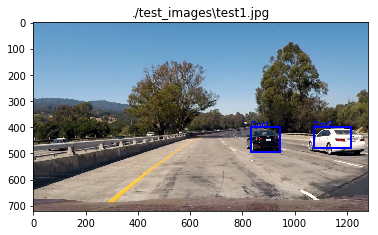

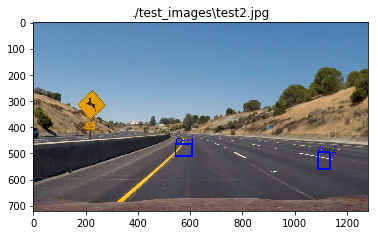

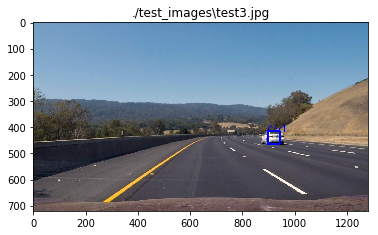

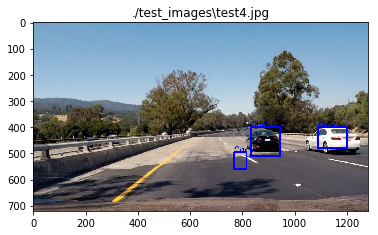

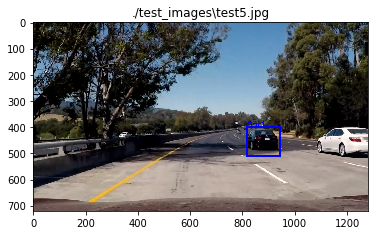

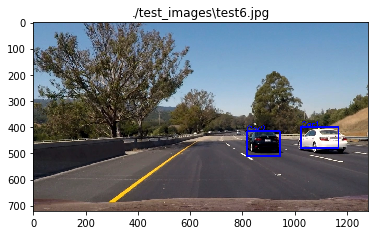

In [24]:
if len(car_features) > 0:
    
    for impath in glob.glob('./test_images/test*.jpg'):
        image = mpimg.imread(impath)
        draw_img = process_each_image (image)
        showImage(draw_img , '{}'.format(impath)) 


else: 
    print('Your function only returns empty feature vectors...')
plt.show()

In [25]:
test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(process_each_image)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4


100%|█████████▉| 1260/1261 [1:58:21<00:05,  5.64s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

Wall time: 1h 58min 22s
